In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [2]:
def load_data(base_path):
    data = []
    participants = []
    participant_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r') as f:
                        print(f"Loading {file_path}")
                        participants.append(file_path.split("/")[-2])
                        content = json.load(f)
                        groupID = content.get("groupID")
                        participant_ids.append(content.get("participantID"))
                        for response in content.get("responses", []):
                            labels = response["feeling"]["labels"]
                            if groupID not in ["2", "3"]:
                                other = response["feeling"]["other"]
                                if other != "N/A":
                                    if len(other.split()) == 1:
                                        other = other.capitalize()
                                        labels.append(other)
                            data.append({
                                "timestamp": response["timestamp"],
                                "videoTime": response["videoTime"],
                                "labels": labels,
                                "self-caught": response["self-caught"],
                                "probe-caught": response["probe-caught"],
                                "groupID": groupID,
                                "participantID": groupID + "_" +participant_ids[-1],
                                "participant": participants[-1]
                            })
                except json.JSONDecodeError as e:
                    print(f"Skipping invalid JSON file {file_path}: {e}")
    return data, participants, participant_ids

base_path = "../../response-data"
data, participants, participant_ids = load_data(base_path)


Loading ../../response-data/group-3/participant-3/report-20250401-182222.json
Loading ../../response-data/group-3/participant-2/report-20250407-233751.json
Loading ../../response-data/group-3/participant-1/report-20250401-182447.json
Loading ../../response-data/group-9/participant-3/report-20250514-164834.json
Loading ../../response-data/group-9/participant-2/report-20250514-164612.json
Loading ../../response-data/group-9/participant-1/report-20250514-164716.json
Loading ../../response-data/group-5/participant-3/report-20250403-124040.json
Loading ../../response-data/group-5/participant-2/report-20250403-124005.json
Loading ../../response-data/group-5/participant-1/report-20250403-123850.json
Loading ../../response-data/group-6/participant-3/report-20250408-185334.json
Loading ../../response-data/group-6/participant-2/report-20250408-185107.json
Loading ../../response-data/group-6/participant-1/report-20250408-185303.json
Loading ../../response-data/group-4/participant-3/report-2025040

In [3]:
groups = len(participants) // 3
expanded_data = []
for entry in data:
    if len(entry["labels"]) == 0:
        entry["labels"] = ["No Response"]
for entry in data:
    if "Other" in entry["labels"]:
        entry["labels"].remove("Other")
        entry["Other"] = True
    else:
        entry["Other"] = False
for entry in data:
    for label in entry["labels"]:
        new_entry = entry.copy()
        new_entry["labels"] = [label]
        expanded_data.append(new_entry)
data = expanded_data
# for entry in data:
#     for label in entry["labels"]:
#         entry["labels"] = label
data.sort(key=lambda x: (int(x["groupID"]), x["participantID"], x["videoTime"]))

In [4]:
for participant_id in set(entry["participantID"] for entry in data):
    participant_data = [entry for entry in data if entry["participantID"] == participant_id]
    participant_data.sort(key=lambda x: x["videoTime"])  
    for i in range(len(participant_data)):
        if i == 0:
            participant_data[i]["TimeDifference"] = 0 
        else:
            participant_data[i]["TimeDifference"] = (
                participant_data[i]["videoTime"] - participant_data[i - 1]["videoTime"]
            )

In [5]:
data = [entry for entry in data if entry["labels"][0] != 'No Response']
df = pd.DataFrame(data)
df.to_csv("../../output/reports-agg.csv", index=False)

In [6]:
average_time_difference = df["TimeDifference"].mean()
print(f"Average Time Difference (Overall): {average_time_difference:.2f} seconds")
std_dev = df["TimeDifference"].std()
std_error = std_dev / np.sqrt(len(df))
print(f"Standard Deviation: {std_dev:.2f} seconds")
print(f"Standard Error: {std_error:.2f} seconds")
self_caught_df = df[df["self-caught"] == True]
self_caught_avg = self_caught_df["TimeDifference"].mean()
self_caught_std = self_caught_df["TimeDifference"].std()
self_caught_err = self_caught_std / np.sqrt(len(self_caught_df))
print(f"\nSelf-Caught Only - Average Time Difference: {self_caught_avg:.2f} seconds")
print(f"Self-Caught Only - Standard Deviation: {self_caught_std:.2f} seconds")
print(f"Self-Caught Only - Standard Error: {self_caught_err:.2f} seconds")

Average Time Difference (Overall): 40.43 seconds
Standard Deviation: 25.45 seconds
Standard Error: 1.34 seconds

Self-Caught Only - Average Time Difference: 27.98 seconds
Self-Caught Only - Standard Deviation: 18.56 seconds
Self-Caught Only - Standard Error: 1.63 seconds


In [7]:
all_labels = []
for entry in data:
    all_labels.extend(label for label in entry["labels"])
self_caught_labels = []
probe_caught_labels = []
for entry in data:
    for label in entry["labels"]:
        if entry.get("self-caught", False):
            self_caught_labels.append(label)
        elif entry.get("probe-caught", False):
            probe_caught_labels.append(label)
print("Total number of groups:", len(participants) // 3)

Total number of groups: 9


In [8]:
participant_self_caught_counts = {}
participant_probe_caught_counts = {}
for entry in data:
    participant_id = entry.get("participantID", "unknown")  
    if participant_id not in participant_self_caught_counts:
        participant_self_caught_counts[participant_id] = 0
        participant_probe_caught_counts[participant_id] = 0
    if entry.get("self-caught", False):
        participant_self_caught_counts[participant_id] += len(entry["labels"])
    if entry.get("probe-caught", False):
        participant_probe_caught_counts[participant_id] += len(entry["labels"])
print("Self-Caught Label Counts per Participant:")
for participant, count in participant_self_caught_counts.items():
    print(f"Participant {participant}: {count}")
print("\nProbe-Caught Label Counts per Participant:")
for participant, count in participant_probe_caught_counts.items():
    print(f"Participant {participant}: {count}")

Self-Caught Label Counts per Participant:
Participant 2_1: 7
Participant 2_2: 1
Participant 2_3: 1
Participant 3_1: 1
Participant 3_2: 15
Participant 3_3: 5
Participant 4_1: 2
Participant 4_2: 1
Participant 4_3: 13
Participant 5_1: 1
Participant 5_2: 1
Participant 5_3: 9
Participant 6_1: 2
Participant 6_2: 2
Participant 6_3: 4
Participant 7_1: 1
Participant 7_2: 1
Participant 7_3: 1
Participant 8_1: 8
Participant 8_2: 7
Participant 8_3: 1
Participant 9_1: 7
Participant 9_2: 17
Participant 9_3: 11
Participant 10_1: 9
Participant 10_2: 1
Participant 10_3: 0

Probe-Caught Label Counts per Participant:
Participant 2_1: 4
Participant 2_2: 9
Participant 2_3: 10
Participant 3_1: 20
Participant 3_2: 2
Participant 3_3: 3
Participant 4_1: 21
Participant 4_2: 12
Participant 4_3: 4
Participant 5_1: 8
Participant 5_2: 6
Participant 5_3: 3
Participant 6_1: 12
Participant 6_2: 19
Participant 6_3: 16
Participant 7_1: 8
Participant 7_2: 16
Participant 7_3: 11
Participant 8_1: 5
Participant 8_2: 5
Parti

In [9]:
participant_label_counts = {}
participant_self_caught_counts = {}
participant_probe_caught_counts = {}
for entry in data:
    participant_id = entry.get("participantID", "unknown")
    if participant_id not in participant_label_counts:
        participant_label_counts[participant_id] = 0
        participant_self_caught_counts[participant_id] = 0
        participant_probe_caught_counts[participant_id] = 0
    participant_label_counts[participant_id] += len(entry["labels"])
    if entry.get("self-caught", False):
        participant_self_caught_counts[participant_id] += len(entry["labels"])
    if entry.get("probe-caught", False):
        participant_probe_caught_counts[participant_id] += len(entry["labels"])
all_labels_counts = list(participant_label_counts.values())
self_caught_counts = list(participant_self_caught_counts.values())
probe_caught_counts = list(participant_probe_caught_counts.values())
metrics = {
    "Metric": ["Total Count", "Average", "Mean", "SD"],
    "All Labels": [
        sum(all_labels_counts),
        sum(all_labels_counts) / len(all_labels_counts),
        np.mean(all_labels_counts),
        np.std(all_labels_counts)
    ],
    "Self-Caught": [
        sum(self_caught_counts),
        sum(self_caught_counts) / len(self_caught_counts),
        np.mean(self_caught_counts),
        np.std(self_caught_counts)
    ],
    "Probe-Caught": [
        sum(probe_caught_counts),
        sum(probe_caught_counts) / len(probe_caught_counts),
        np.mean(probe_caught_counts),
        np.std(probe_caught_counts)
    ]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df.to_string(index=False))

     Metric  All Labels  Self-Caught  Probe-Caught
Total Count  359.000000   129.000000    230.000000
    Average   13.296296     4.777778      8.518519
       Mean   13.296296     4.777778      8.518519
         SD    4.665197     4.809969      5.685396


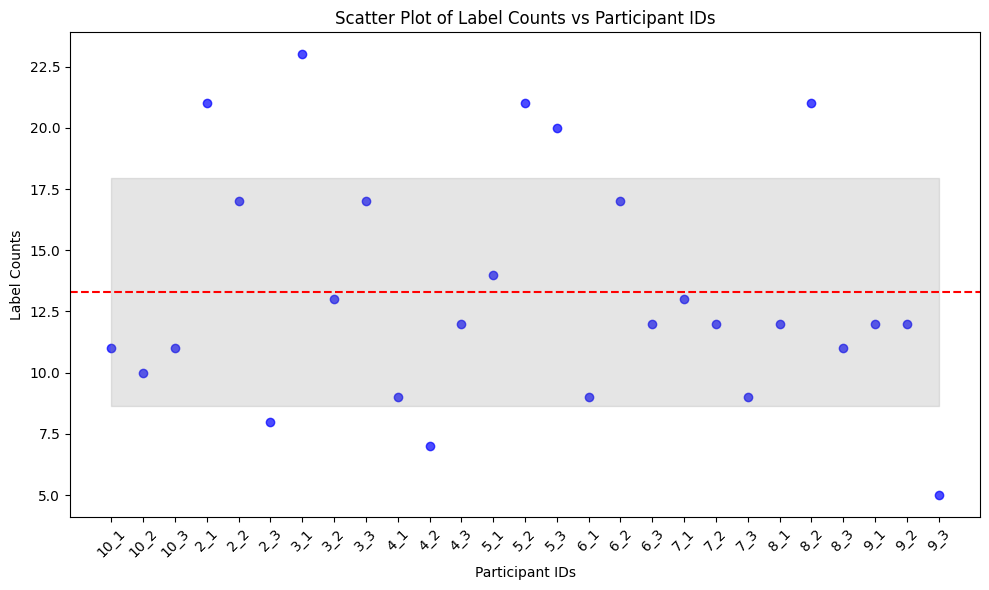

In [10]:
import matplotlib.pyplot as plt
participant_ids = sorted(participant_label_counts.keys())
label_counts = list(participant_label_counts.values())
plt.figure(figsize=(10, 6))
plt.scatter(participant_ids, label_counts, color="blue", alpha=0.7)
plt.xlabel("Participant IDs")
plt.ylabel("Label Counts")
plt.title("Scatter Plot of Label Counts vs Participant IDs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.axhline(y=np.mean(label_counts), color='r', linestyle='--', label='Average')
plt.fill_between(
    participant_ids,
    np.mean(label_counts) - np.std(label_counts),
    np.mean(label_counts) + np.std(label_counts),
    color='gray',
    alpha=0.2,
    label='1 SD Range'
)
plt.show()

In [11]:
label_counts = Counter(all_labels)
label_df = pd.DataFrame(label_counts.items(), columns=["Label", "Frequency"]).sort_values(by="Frequency", ascending=False)
print(label_df)

           Label  Frequency
2     Optimistic         91
0        Curious         82
4       Confused         66
3     Conflicted         24
1      Surprised         22
5     Disengaged         21
6     Frustrated         19
8        Engaged          9
15         Happy          4
13          Sure          4
17        Amused          2
16         Funny          2
19  Anticipation          2
7      Motivated          1
11     Agreeable          1
9        Annoyed          1
14  Accomplished          1
12        Elated          1
10       Certain          1
18           Lol          1
20         Humor          1
21     Agreement          1
22       Focused          1
23      Planning          1


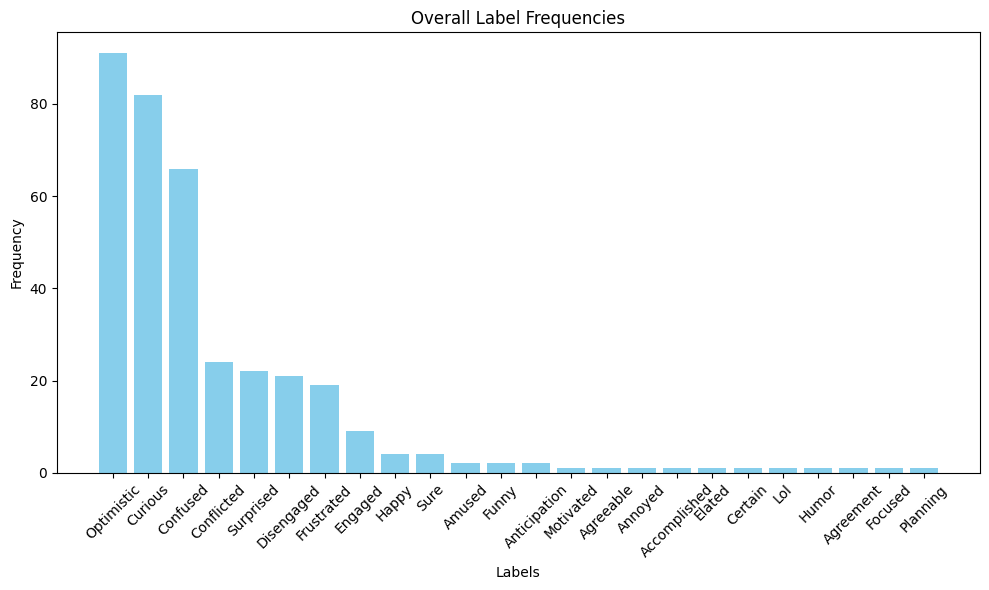

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(label_df["Label"], label_df["Frequency"], color="skyblue")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Overall Label Frequencies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

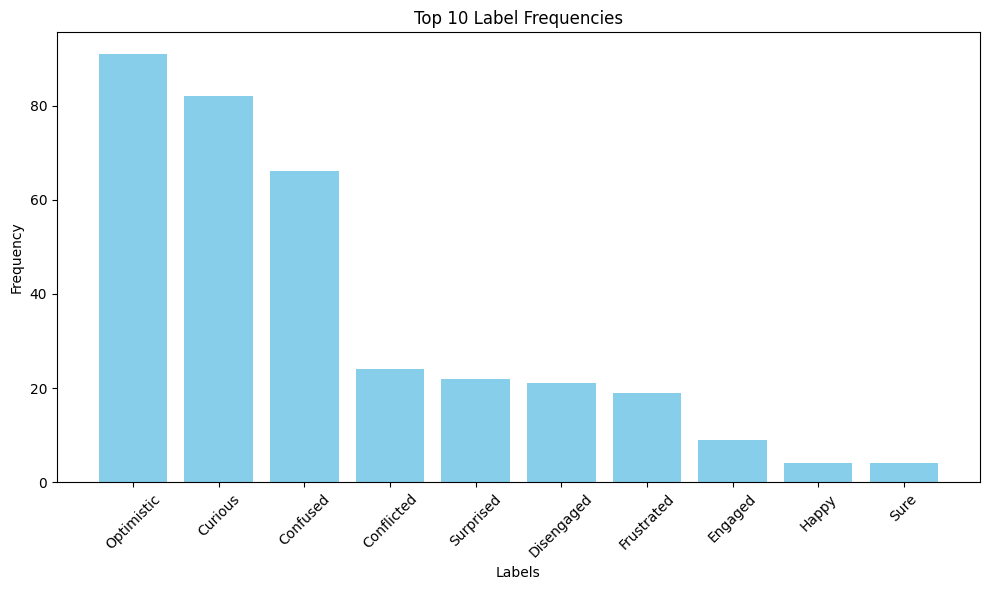

In [13]:
top_10_labels = label_df.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top_10_labels["Label"], top_10_labels["Frequency"], color="skyblue")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Top 10 Label Frequencies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
self_caught_counts = Counter(self_caught_labels)
self_caught_df = pd.DataFrame(self_caught_counts.items(), columns=["Label", "Frequency"]).sort_values(by="Frequency", ascending=False)

probe_caught_counts = Counter(probe_caught_labels)
probe_caught_df = pd.DataFrame(probe_caught_counts.items(), columns=["Label", "Frequency"]).sort_values(by="Frequency", ascending=False)

all_labels = set(self_caught_df["Label"]).union(set(probe_caught_df["Label"]))
self_caught_df = self_caught_df.set_index("Label").reindex(all_labels, fill_value=0).reset_index()
probe_caught_df = probe_caught_df.set_index("Label").reindex(all_labels, fill_value=0).reset_index()

self_caught_df = self_caught_df.sort_values(by="Frequency", ascending=False)
probe_caught_df = probe_caught_df.sort_values(by="Frequency", ascending=False)

print("Self-Caught Labels Frequency:")
print(self_caught_df)

print("\nProbe-Caught Labels Frequency:")
print(probe_caught_df)

Self-Caught Labels Frequency:
           Label  Frequency
9       Confused         29
14    Optimistic         27
2        Curious         22
10    Conflicted         12
1     Frustrated         10
6      Surprised          8
8     Disengaged          7
16         Happy          4
21         Funny          2
23           Lol          1
7          Humor          1
3   Anticipation          1
0      Agreeable          1
18        Elated          1
11        Amused          1
13       Focused          1
22          Sure          1
5        Engaged          0
4        Annoyed          0
12      Planning          0
15     Motivated          0
17  Accomplished          0
19       Certain          0
20     Agreement          0

Probe-Caught Labels Frequency:
           Label  Frequency
14    Optimistic         64
2        Curious         60
9       Confused         37
6      Surprised         14
8     Disengaged         14
10    Conflicted         12
5        Engaged          9
1     Frustrat

In [15]:
top_10_self_caught = self_caught_df.head(10)
top_10_probe_caught = probe_caught_df.head(10)
print("Top 10 Self-Caught Labels:")
print(top_10_self_caught)
print("\nTop 10 Probe-Caught Labels:")
print(top_10_probe_caught)


Top 10 Self-Caught Labels:
         Label  Frequency
9     Confused         29
14  Optimistic         27
2      Curious         22
10  Conflicted         12
1   Frustrated         10
6    Surprised          8
8   Disengaged          7
16       Happy          4
21       Funny          2
23         Lol          1

Top 10 Probe-Caught Labels:
           Label  Frequency
14    Optimistic         64
2        Curious         60
9       Confused         37
6      Surprised         14
8     Disengaged         14
10    Conflicted         12
5        Engaged          9
1     Frustrated          9
22          Sure          3
17  Accomplished          1


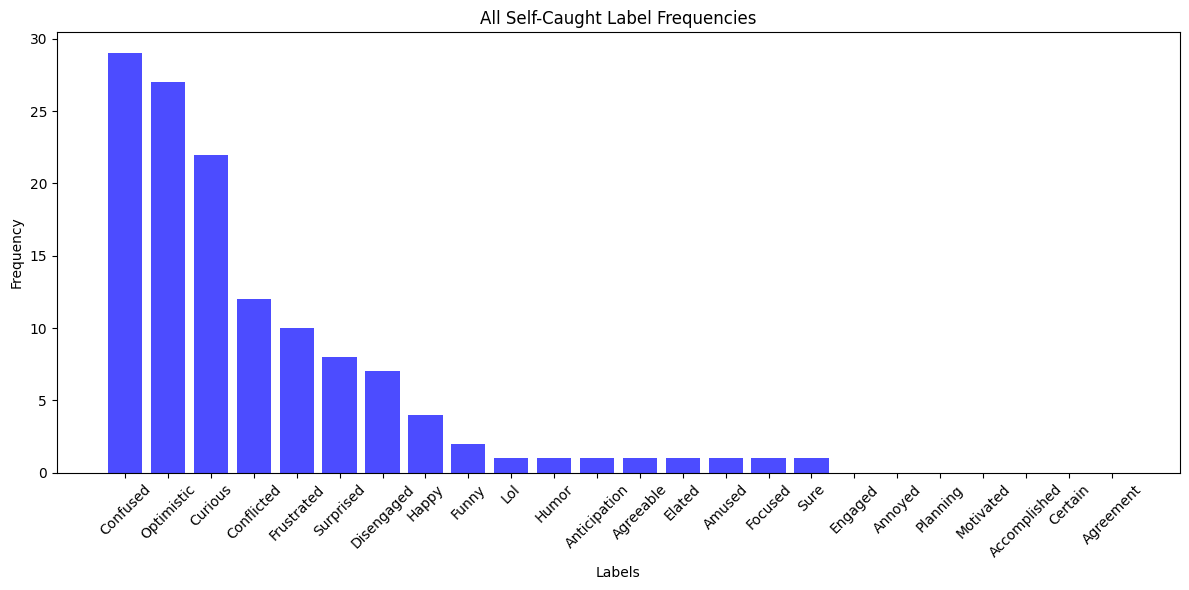

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(self_caught_df["Label"], self_caught_df["Frequency"], color="blue", alpha=0.7)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("All Self-Caught Label Frequencies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

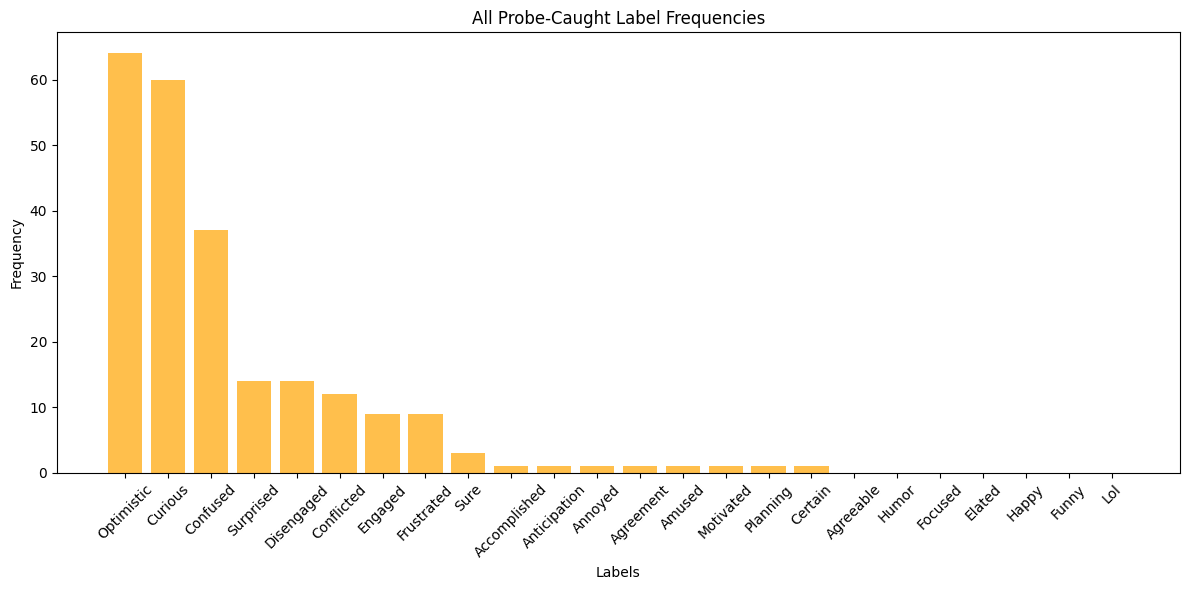

In [17]:
plt.figure(figsize=(12, 6))
plt.bar(probe_caught_df["Label"], probe_caught_df["Frequency"], color="orange", alpha=0.7)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("All Probe-Caught Label Frequencies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

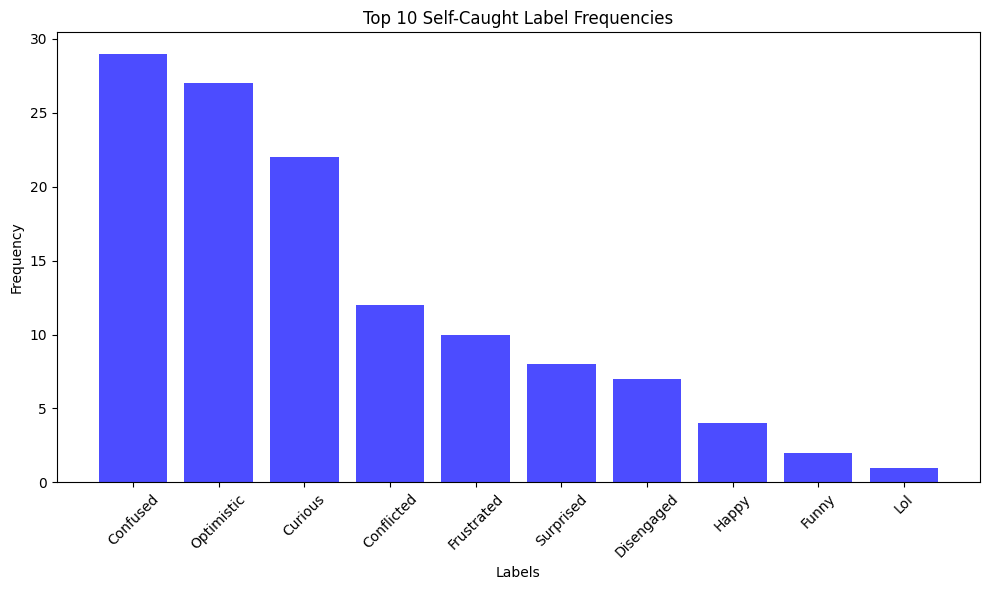

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(top_10_self_caught["Label"], top_10_self_caught["Frequency"], color="blue", alpha=0.7)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Top 10 Self-Caught Label Frequencies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

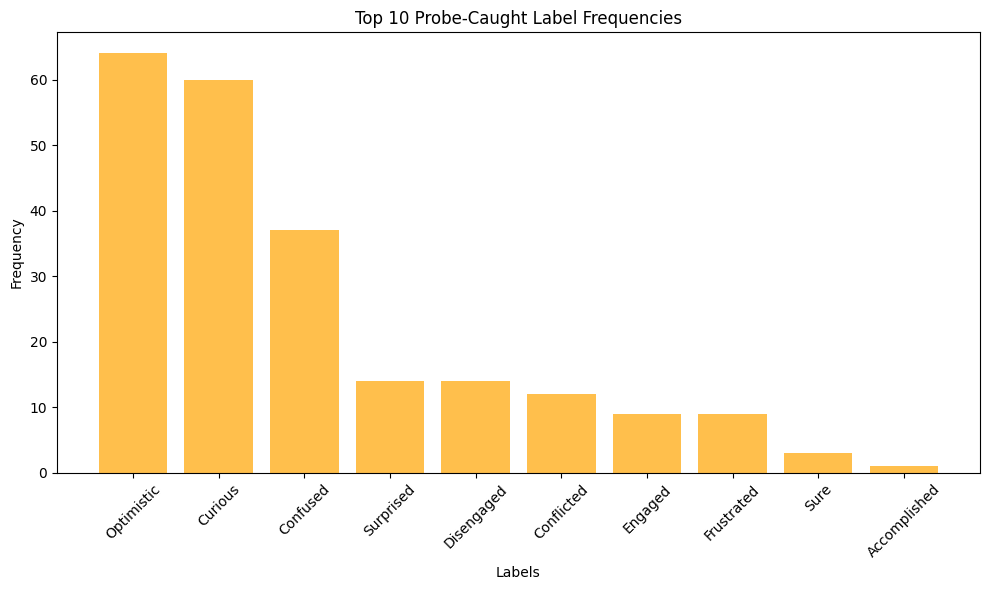

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(top_10_probe_caught["Label"], top_10_probe_caught["Frequency"], color="orange", alpha=0.7)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Top 10 Probe-Caught Label Frequencies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

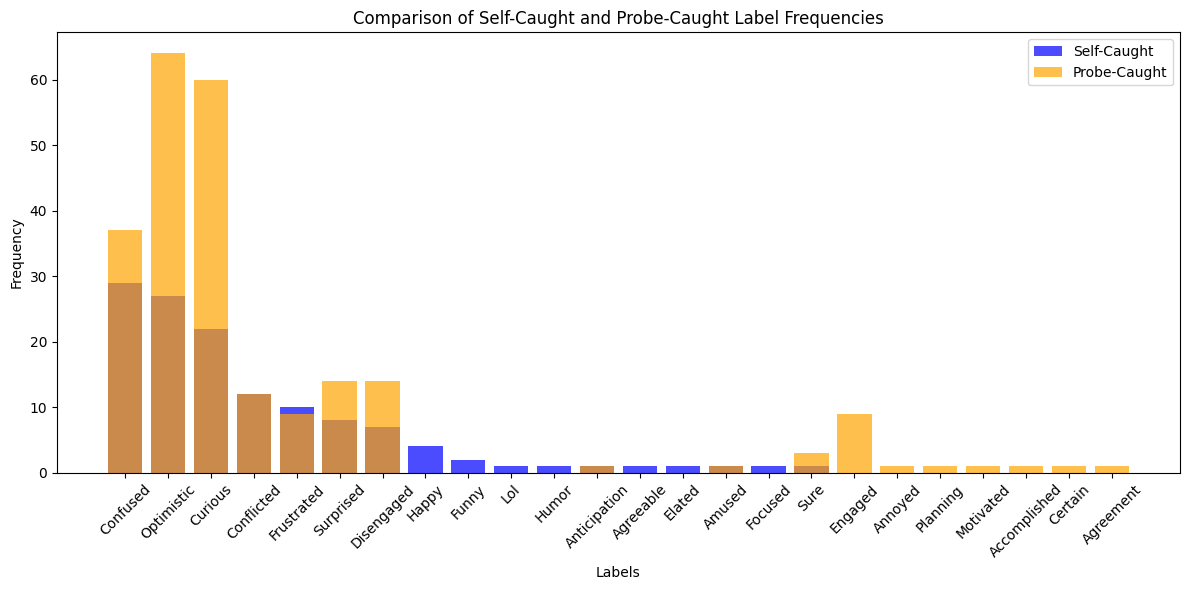

In [20]:
plt.figure(figsize=(12, 6))
plt.bar(self_caught_df["Label"], self_caught_df["Frequency"], color="blue", alpha=0.7, label="Self-Caught")
plt.bar(probe_caught_df["Label"], probe_caught_df["Frequency"], color="orange", alpha=0.7, label="Probe-Caught")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Comparison of Self-Caught and Probe-Caught Label Frequencies")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# def normalize_time(data):
#     for entry in data:
#         entry["normalizedTime"] = entry["videoTime"] / max(d["videoTime"] for d in data if d["videoTime"] > 0)
#     return data

def normalize_time_by_group(data):
    group_data = {}
    for entry in data:
        group_id = entry["groupID"]
        if group_id not in group_data:
            group_data[group_id] = []
        group_data[group_id].append(entry)
    for group_id, entries in group_data.items():
        max_time = max(entry["videoTime"] for entry in entries if entry["videoTime"] > 0)
        for entry in entries:
            entry["normalizedTimeGroup"] = entry["videoTime"] / max_time
    for entry in data:
        group_id = entry["groupID"]
        entry["normalizedTimeGroup"] = entry.get("normalizedTimeGroup", 0)
    return data
# data = normalize_time(data) ## This was a mistake, we should normalize by group
data = normalize_time_by_group(data)

In [22]:
scatter_data = []
for entry in data:
    for label in entry["labels"]:
        scatter_data.append({"normalizedTimeGroup": entry["normalizedTimeGroup"], "label": label})
scatter_df = pd.DataFrame(scatter_data)


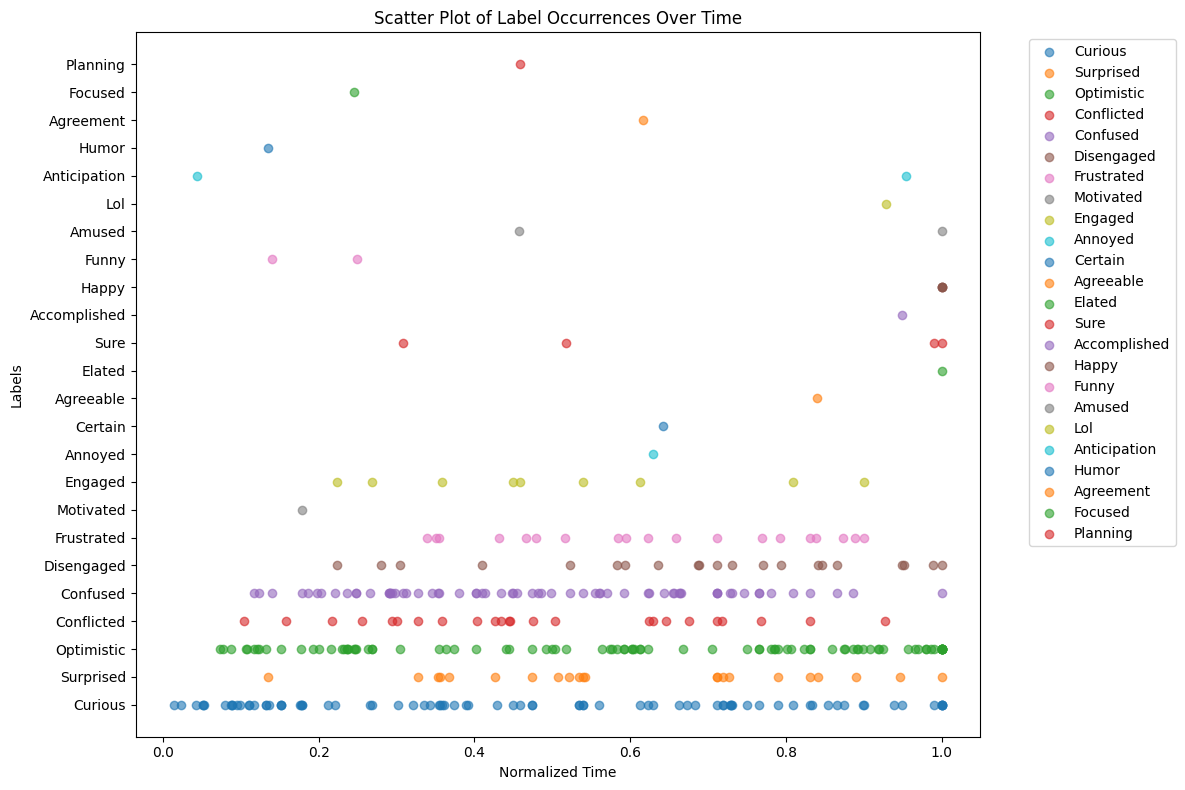

In [23]:
plt.figure(figsize=(12, 8))
for label in scatter_df["label"].unique():
    subset = scatter_df[scatter_df["label"] == label]
    plt.scatter(subset["normalizedTimeGroup"], [label] * len(subset), label=label, alpha=0.6)
plt.xlabel("Normalized Time")
plt.ylabel("Labels")
plt.title("Scatter Plot of Label Occurrences Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [24]:
scatter_data = []
for entry in data:
    for label in entry["labels"]:
        scatter_data.append({"normalizedTimeGroup": entry["normalizedTimeGroup"], "label": label, "participantID": entry["participantID"]})

scatter_df = pd.DataFrame(scatter_data)

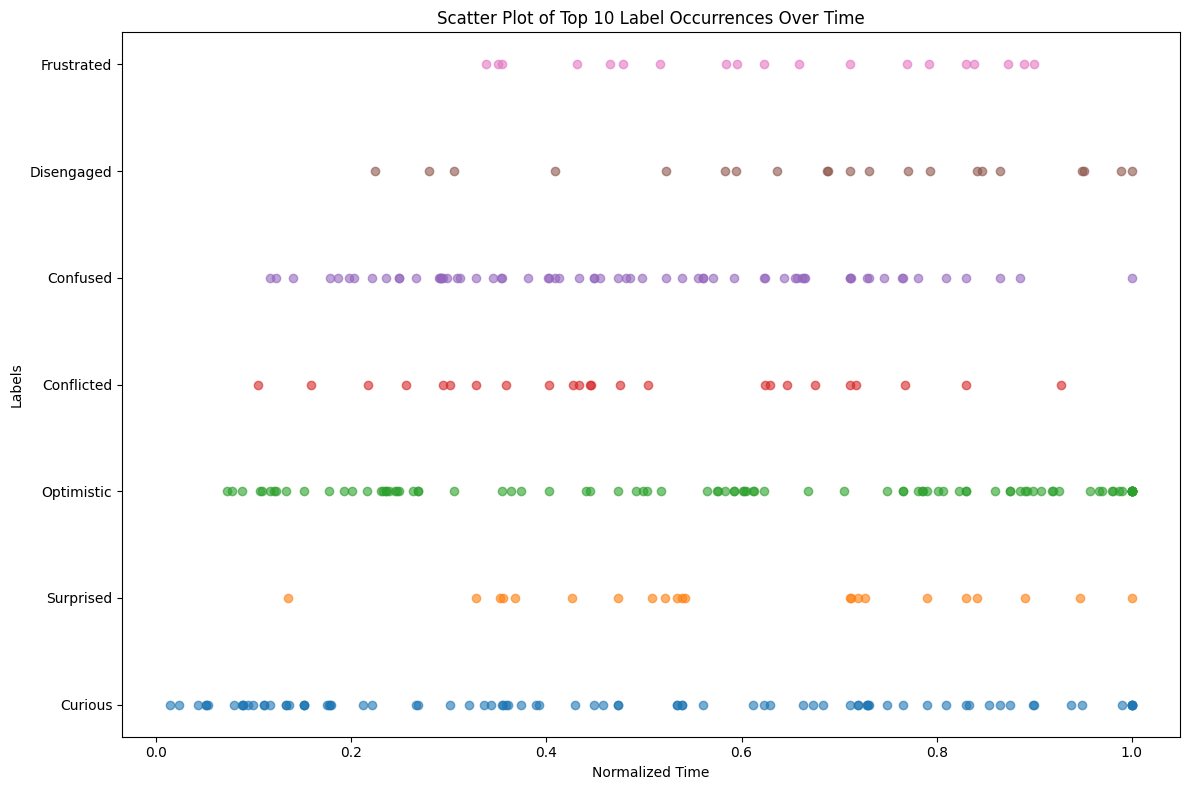

In [25]:
top_10_label_names = top_10_labels["Label"].tolist()
top_7_label_names = top_10_labels["Label"].tolist()[:7]
scatter_data_top_10 = scatter_df[scatter_df["label"].isin(top_10_label_names)]
scatter_data_top_10 = scatter_data_top_10[scatter_data_top_10["label"].isin(top_7_label_names)]
plt.figure(figsize=(12, 8))
for label in scatter_data_top_10["label"].unique():
    subset = scatter_data_top_10[scatter_data_top_10["label"] == label]
    plt.scatter(subset["normalizedTimeGroup"], [label] * len(subset), label=label, alpha=0.6)
plt.xlabel("Normalized Time")
plt.ylabel("Labels")
plt.title("Scatter Plot of Top 10 Label Occurrences Over Time")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [26]:
os.makedirs("../output/distribution/participants", exist_ok=True)
os.makedirs("../output/distribution/groups", exist_ok=True)
import seaborn as sns

def save_participant_plots(data):
    for participant_id in set(entry["participantID"] for entry in data):
        participant_data = [entry for entry in data if entry["participantID"] == participant_id]
        participant_df = pd.DataFrame(participant_data)
        label_counts = Counter(label for entry in participant_data for label in entry["labels"])
        label_df = pd.DataFrame(label_counts.items(), columns=["Label", "Frequency"]).sort_values(by="Frequency", ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Label", y="Frequency", data=label_df, palette="viridis")
        plt.title(f"Label Distribution for Participant {participant_id}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"../output/distribution/participants/{participant_id}_label_distribution.png")
        plt.close()
        plt.figure(figsize=(12, 8))
        for label in participant_df["labels"].explode().unique():
            subset = participant_df[participant_df["labels"].apply(lambda x: label in x)]
            plt.scatter(subset["normalizedTimeGroup"], [label] * len(subset), label=label, alpha=0.6)
        plt.xlabel("Normalized Time")
        plt.ylabel("Labels")
        plt.title(f"Scatter Plot of Labels Over Time for Participant {participant_id}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
        plt.tight_layout()
        plt.savefig(f"../output/distribution/participants/{participant_id}_scatterplot.png")
        plt.close()

def save_group_plots(data):
    for group_id in set(entry["groupID"] for entry in data):
        group_data = [entry for entry in data if entry["groupID"] == group_id]
        group_df = pd.DataFrame(group_data)
        label_counts = Counter(label for entry in group_data for label in entry["labels"])
        label_df = pd.DataFrame(label_counts.items(), columns=["Label", "Frequency"]).sort_values(by="Frequency", ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Label", y="Frequency", data=label_df, palette="viridis")
        plt.title(f"Label Distribution for Group {group_id}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"../output/distribution/groups/{group_id}_label_distribution.png")
        plt.close()
        plt.figure(figsize=(12, 8))
        for label in group_df["labels"].explode().unique():
            subset = group_df[group_df["labels"].apply(lambda x: label in x)]
            plt.scatter(subset["normalizedTimeGroup"], [label] * len(subset), label=label, alpha=0.6)
        plt.xlabel("Normalized Time")
        plt.ylabel("Labels")
        plt.title(f"Scatter Plot of Labels Over Time for Group {group_id}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
        plt.tight_layout()
        plt.savefig(f"../output/distribution/groups/{group_id}_scatterplot.png")
        plt.close()

save_participant_plots(data)
save_group_plots(data)

/tmp/ipykernel_1578188/3812471279.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Label", y="Frequency", data=label_df, palette="viridis")
/tmp/ipykernel_1578188/3812471279.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Label", y="Frequency", data=label_df, palette="viridis")
/tmp/ipykernel_1578188/3812471279.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Label", y="Frequency", data=label_df, palette="viridis")
/tmp/ipykernel_1578188/3812471279.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is dep

Group Summary:
Group 9: Curious (8), Optimistic (8), Confused (4), Disengaged (4), Engaged (2) - Total Task Time: 337 seconds
Group 5: Confused (11), Curious (10), Optimistic (9), Disengaged (7), Conflicted (7) - Total Task Time: 1102 seconds
Group 6: Optimistic (10), Confused (8), Curious (8), Surprised (3), Frustrated (3) - Total Task Time: 453 seconds
Group 3: Curious (19), Optimistic (9), Engaged (6), Confused (6), Surprised (4) - Total Task Time: 661 seconds
Group 8: Curious (11), Confused (9), Disengaged (6), Frustrated (6), Optimistic (5) - Total Task Time: 392 seconds
Group 2: Optimistic (15), Confused (11), Curious (7), Surprised (5), Conflicted (4) - Total Task Time: 634 seconds
Group 4: Optimistic (10), Curious (8), Confused (4), Surprised (2), Conflicted (1) - Total Task Time: 480 seconds
Group 7: Confused (8), Optimistic (8), Curious (5), Funny (2), Amused (2) - Total Task Time: 518 seconds
Group 1: Optimistic (17), Curious (6), Confused (5), Surprised (2), Conflicted (1) 

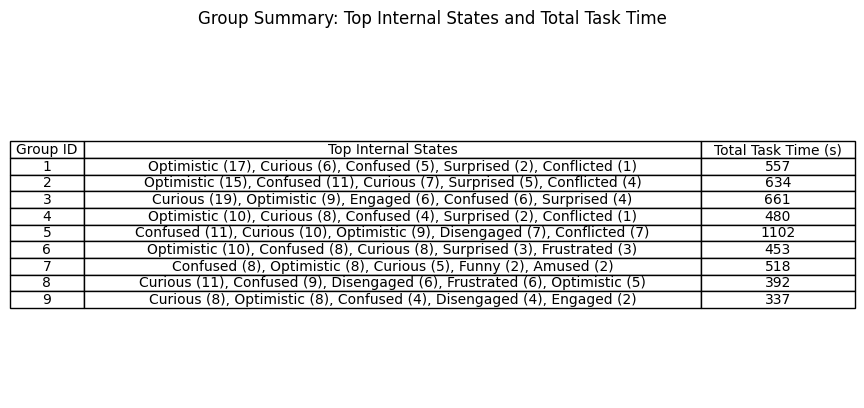

In [27]:
def generate_group_summary_table(data):
    group_summary = []
    for group_id in set(entry["groupID"] for entry in data):
        group_data = [entry for entry in data if entry["groupID"] == group_id]
        group_df = pd.DataFrame(group_data)
        total_time = group_df["videoTime"].max() - group_df["videoTime"].min()
        label_counts = Counter(label for entry in group_data for label in entry["labels"])
        top_labels = label_counts.most_common(5)
        group_summary.append({
            "Group ID": int(group_id) - 1,
            "Top Internal States": ", ".join([f"{label} ({count})" for label, count in top_labels]),
            "Total Task Time (s)": total_time
        })
    print("Group Summary:")
    for summary in group_summary:
        print(f"Group {summary['Group ID']}: {summary['Top Internal States']} - Total Task Time: {summary['Total Task Time (s)']} seconds")
    summary_df = pd.DataFrame(group_summary)
    summary_df["Group ID"] = summary_df["Group ID"].astype(int)
    summary_df = summary_df.sort_values(by="Group ID").reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(10, len(group_summary) * 0.5))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc="center", loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(summary_df.columns))))
    plt.title("Group Summary: Top Internal States and Total Task Time", fontsize=12, pad=20)
    plt.savefig("../output/distribution/groups/group_summary_table.png", bbox_inches="tight")
    plt.show()
    plt.close()

generate_group_summary_table(data)